### Import packages

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.cluster
import sklearn.neighbors
import scipy

from util import config
from util import mapping
from util import road_backbone

# Remove gaps in rides - DBSCAN

GPS-recorded rides can have some issues with gaps in the data.  This could be an issue with the machine, or an issue with the human, e.g. forgetting to turn the unit back on for a while after pausing.

Here, look for long gaps in each ride, and take the longest continuous segment out of each.  Ideally, the longest continuous segment will be the whole ride!  That is, DBSCAN identifies the whole ride as a single, continuous cluster.

To find continuous segments, I use DBSCAN because

* Want to extract contiguous segments, so density-based clustering is ideal
* DBSCAN is the best density-based option, because it is intuitive to define 'epsilon' (maximum distance between points in this cluster) in geographic space

In [57]:
trips = pd.read_feather(
    os.path.join(config.PROCESSED_DATA_PATH, 'trips.feather')
)
trips.set_index('rte_id', inplace=True)


# If everything is working well, GPS points should be < 20 m apart
# However, a user's tolerance is much higher than this - as long as
# ride is easy to follow in map view, it is fine for this purpose.
clusterer = sklearn.cluster.DBSCAN(eps=0.1) # 0.1 degree ~ 1 km

bad_rtes = []
for i, rte_id in enumerate(trips.index.tolist()):
    if not i % 200: print('{} of {}'.format(i, trips.shape[0]))
    
    ride = pd.read_feather(
        os.path.join(config.CLEAN_TRIPS_PATH, '{}.feather'.format(rte_id))
    )
    # Use DBSCAN to find clusters in the ride    
    clusterer.fit(ride[['lat', 'lon']])
    ride['labels'] = clusterer.labels_
    
    # Remove any points classed as noise (label = -1)
    ride = ride[ride.labels >= 0]
    
    # Ideally, there will only be one cluster!  That is, all points
    # along the ride are fairly continuous, with no large gaps > 1 km
    if ride.labels.nunique() == 1:
        continue
        
    # If there is more than one cluster, this ride needs dealing with...
    bad_rtes += [ride] # Just to keep track
    
    # Find segment with largest number of breadcrumb points
    biggest_segment = ride.labels.value_counts().index[0]
    
    # Only keep that longest segment
    ride = (ride[ride.labels == biggest_segment]
            .reset_index(drop=True).drop('labels', axis=1))
    
    # If this now means that the ride is very short, drop it
    if ride['dist'].sum() <= 1:
        os.remove(os.path.join(config.CLEAN_TRIPS_PATH, '{}.feather'.format(rte_id)))
        continue
    
    ride.to_feather(
        os.path.join(config.CLEAN_TRIPS_PATH, '{}.feather'.format(rte_id))
    )
    

0 of 19570
200 of 19570
400 of 19570
600 of 19570
800 of 19570
1000 of 19570
1200 of 19570
1400 of 19570
1600 of 19570
1800 of 19570
2000 of 19570
2200 of 19570
2400 of 19570
2600 of 19570
2800 of 19570
3000 of 19570
3200 of 19570
3400 of 19570
3600 of 19570
3800 of 19570
4000 of 19570
4200 of 19570
4400 of 19570
4600 of 19570
4800 of 19570
5000 of 19570
5200 of 19570
5400 of 19570
5600 of 19570
5800 of 19570
6000 of 19570
6200 of 19570
6400 of 19570
6600 of 19570
6800 of 19570
7000 of 19570
7200 of 19570
7400 of 19570
7600 of 19570
7800 of 19570
8000 of 19570
8200 of 19570
8400 of 19570
8600 of 19570
8800 of 19570
9000 of 19570
9200 of 19570
9400 of 19570
9600 of 19570
9800 of 19570
10000 of 19570
10200 of 19570
10400 of 19570
10600 of 19570
10800 of 19570
11000 of 19570
11200 of 19570
11400 of 19570
11600 of 19570
11800 of 19570
12000 of 19570
12200 of 19570
12400 of 19570
12600 of 19570
12800 of 19570
13000 of 19570
13200 of 19570
13400 of 19570
13600 of 19570
13800 of 19570
14000 o

Check out some of those discontinuous trips visually.  These are plotted so different segments of the same ride are in a darker colour, e.g. light blue/dark blue are part of the same recorded ride, but show a large gap between two segments.

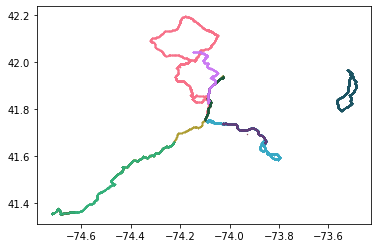

In [68]:
colours = sns.color_palette('husl', 5)
inds = np.random.choice(len(bad_rtes), 5, replace=False)

for n, ind in enumerate(inds):
    ride = bad_rtes[ind]
    for i, cluster_label in enumerate(ride.labels.value_counts().index.tolist()):
        plt.plot(ride[ride.labels == cluster_label].lon,
                 ride[ride.labels == cluster_label].lat,
                 '.', markersize=0.5, 
                 color=(np.array(colours[n]) 
                       * (ride.labels.nunique() - i) / ride.labels.nunique())
                )

And remove any of these deleted trips from the main DataFrame.

In [95]:
trips = pd.read_feather(
    os.path.join(config.PROCESSED_DATA_PATH, 'trips.feather')
)
print(trips.shape)
# List all [rte_id].feather files in CLEAN_TRIPS_PATH
clean_trip_ids = [rte_id.stem for rte_id 
                  in pathlib.Path(config.CLEAN_TRIPS_PATH).glob('*.feather')]


trips = trips[(trips['rte_id'].isin(clean_trip_ids))].reset_index(drop=True)
print(trips.shape)
trips.to_feather(
    os.path.join(config.PROCESSED_DATA_PATH, 'trips.feather')
)

(19570, 9)
(19570, 9)


## Build the road backbone - CLIQUE-inspired

The lat/lon breadcrumbs are inconsistent across all the rides.  To make life easier, need to build a backbone of consistent lat/lon points along all of the roads included in the database.

Custom clustering inspired by CLIQUE is ideal

* Can choose the mesh size a priori that is appropriate for the task
* Above some threshold (e.g. one ride), data density does not matter - so will not get more cluster centres where there are more rides
* Cluster centres are evenly distributed in space at the granularity that you decide is appropriate

For the basic road backbone, a granularity of around 200 m (0.002 degrees) seems appropriate - except very close to junctions, this can distinguish between different roads.

Later, I will want to calculate distances between points with low latency - as the user puts their preferred start location into the app, I need to calculate how far it is to any given ride.  As distances of less than 1 mile are unlikely to be significant in this proximity question, we can use a coarser granularity (0.015 degrees).

For the de-duping question, an even coarser grid can be used - I would rather throw out rides that are a little bit different than retain them.  This also makes the clustering at that stage easier.  I use a granularity of around 3.5 miles (0.05 degrees).

### Sidebar on CLIQUE-inspired clustering
CLIQUE clustering divides the feature space into a non-overlapping mesh of 2D cells; identifies 'dense cells', which exceed some a priori density threshold; iteratively merges cells pairwise into higher dimensional cells (i.e. 2D -> 3D; 3D -> 4D, etc) and checks against the density threshold; finds the maximal regions for each set of connected, dense, k-dimensional cells.  

In my case, I am only concerned with 2 dimensions total (latitude, longitude), so do not need to do any cell merging. I also only care about identifying dense cells (in this case, at least 1 ride in the cell), not about finding connected regions.  Having identified dense cells, I use the centroid of each cell to approximate the road location in that cell.

In [97]:
trips = pd.read_feather(
    os.path.join(config.PROCESSED_DATA_PATH, 'trips.feather')
)
trips.set_index('rte_id', inplace=True)


We want to address de-duping first, as this will make everything else run much more quickly :)

In [98]:
pts_per_degree = 20

grid_pts, rtes_at_grid, gridpts_at_rte = (
    road_backbone.make_road_backbone(trips.index.tolist(), 
                                     pts_per_degree)
)



Looping through route IDs
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
Total unique grid points: 1010


In [99]:
# And save
config.save_df(grid_pts, config.MODEL_PATH
               'grid_pts_{}.feather'.format(pts_per_degree))
config.save_df(rtes_at_grid, config.MODEL_PATH,
              'rtes_at_grid_{}.feather'.format(pts_per_degree))
config.save_df(gridpts_at_rte, config.MODEL_PATH, 
              'gridpts_at_rte_{}.feather'.format(pts_per_degree))

### De-duping
With a really coarse grid, perform DBSCAN to identify clusters.

Note that we are using clustering to identify duplicates here.  We don't really care about the clusters themselves.  The thing that is interesting are the rides that do not cluster, i.e. the noise.  However, we can still make use of the clustered rides by extracting one ride from each cluster.

In [4]:
pts_per_degree = 20
grid_pts = pd.read_feather(
    os.path.join(config.MODEL_PATH, 'grid_pts_{}.feather'.format(pts_per_degree))
)
rtes_at_grid = pd.read_feather(
    os.path.join(config.MODEL_PATH, 'rtes_at_grid_{}.feather'.format(pts_per_degree))
)
gridpts_at_rte = pd.read_feather(
    os.path.join(config.MODEL_PATH, 'gridpts_at_rte_{}.feather'.format(pts_per_degree))
)
grid_pts.set_index('grid_id', inplace=True)
rtes_at_grid.set_index('grid_id', inplace=True)
gridpts_at_rte.set_index('rte_id', inplace=True)

In [5]:
rte_grid_ohe = gridpts_at_rte.copy() # Make DataFrame with index of rte_id
rte_grid_ohe.drop('grid_ids', axis=1, inplace=True)

for i, grid_id in enumerate(rtes_at_grid.index.tolist()):
    if not i % 200: print(i)
    rte_grid_ohe[grid_id] = False # Instantiate column for grid_id
    # Set value to True at all rte_ids that go through that grid point
    rte_grid_ohe.loc[rtes_at_grid.loc[grid_id].rte_ids, grid_id] = True

    
# For the sake of saving, column names have to be strings
a = dict()
for gi in rte_grid_ohe.columns:
    a[gi] = str(gi)
rte_grid_ohe.rename(columns=a).reset_index().to_feather(
    os.path.join(config.PROCESSED_DATA_PATH, 
                 'gridpts_at_rte_{}_ohe.feather'.format(pts_per_degree))
)

0
200
400
600
800
1000


In [6]:
rte_grid_ohe = pd.read_feather(
    os.path.join(config.PROCESSED_DATA_PATH, 
                 'gridpts_at_rte_{}_ohe.feather'.format(pts_per_degree))
)
rte_grid_ohe.set_index('rte_id', inplace=True)

# This OHE grid is very sparse - convert to sparse CSR matrix for calculation efficiency
sda = scipy.sparse.csr_matrix(rte_grid_ohe.values)
print('{} sparse values'.format(sda.nnz))

174107 sparse values


Cluster! This will efficiently identify rides that go through the same gridpoints (eps = 0.5, where the distance between any non-identical points is 1, as all values are Boolean; min_samples = 2, because we  want to remove all duplicates, not just rides that are repeated 100 times)

Note that DBSCAN works on sparse arrays - so this is pretty quick!

In [7]:
# DBSCAN cluster
clusterer = sklearn.cluster.DBSCAN(min_samples=2, eps=0.5)
clusterer.fit(sda)

DBSCAN(min_samples=2)

In [8]:
# See how big each of the clusters is
rte_clustered = gridpts_at_rte.copy()
rte_clustered['labels'] = clusterer.labels_

rte_clustered.reset_index().to_feather(
    os.path.join(config.MODEL_PATH, 'rts_clustered_{}.feather'.format(pts_per_degree))
)

lab_counts = rte_clustered.labels.value_counts().reset_index().rename(
    columns={'index': 'label', 'labels': 'n_rtes'})
print('{} unique clusters'.format(lab_counts.shape[0] - 1 
                                  + lab_counts[lab_counts.label == -1].n_rtes[0]))
lab_counts.head() # Show distribution

6592 unique clusters


,label,n_rtes
0,-1,4240
1,66,196
2,363,173
3,184,130
4,17,122


In [52]:
# Cluster (-1) are all 'noise' - in this case, unique rides!
# For other clusters, select the first one (arbitrarily - we just want
# to keep only one from each cluster)
gridpts_at_rte = pd.read_feather(
    os.path.join(config.MODEL_PATH, 'gridpts_at_rte_20.feather')
)
rte_clustered = pd.read_feather(
    os.path.join(config.MODEL_PATH, 'rts_clustered_20.feather'.format(pts_per_degree))
)
rte_clustered.set_index('rte_id', inplace=True)

RTE_IDS = rte_clustered[rte_clustered.labels == -1].index.tolist()
for lab in lab_counts.label:
    if lab == -1: continue
    RTE_IDS += [rte_clustered[rte_clustered.labels == lab].index[0]]
    
a = pd.DataFrame(pd.Series(RTE_IDS, dtype='int', name='rte_id'))
a.to_feather(
    os.path.join(config.PROCESSED_DATA_PATH, 'deduped_rte_ids.feather')
)
print('{} unique rides of {} in dataset ({:.0f}% retained)'.format(
    a.shape[0], gridpts_at_rte.shape[0], 
    a.shape[0]/gridpts_at_rte.shape[0] * 100)
     )

6592 unique rides of 19570 in dataset (34% retained)


In [57]:
# Save de-duped trip information
trips = pd.read_feather(
    os.path.join(config.PROCESSED_DATA_PATH, 'trips.feather')
)
trips = trips[trips.rte_id.isin(RTE_IDS)].reset_index() # Keep only unique rides
config.save_df(trips, config.PROCESSED_DATA_PATH,
               'trips_deduped.feather')

## Make Road Backbone

Here, we can make the road backbone at two granularities (for plotting and for calculating distances with low latency in the web app).

This is much faster now we have removed the 65% of the dataset that is just repeated!

In [35]:
gridpts_at_rte.head()

,rte_id,grid_ids
0,23209396,"[1167647, 1167648, 1167649, 1169147, 1169149, ..."
1,54372107,"[1167644, 1167645, 1169144, 1169145, 1169146, ..."
2,48496079,"[1085215, 1085216, 1086715, 1086716, 1088216, ..."
3,40433541,"[1046113, 1046114, 1047613, 1047614, 1047615, ..."
4,56203693,"[1106216, 1107713, 1107714, 1107715, 1107716, ..."


In [22]:
trips = pd.read_feather(
    os.path.join(config.PROCESSED_DATA_PATH, 'trips_deduped.feather')
)
trips.set_index('rte_id', inplace=True)


In [25]:
pts_per_degree = 67

grid_pts, rtes_at_grid, gridpts_at_rte = (
    road_backbone.make_road_backbone(trips.index.tolist(), 
                                     pts_per_degree)
)

# And save
config.save_df(grid_pts, config.MODEL_PATH
               'grid_pts_{}.feather'.format(pts_per_degree))
config.save_df(rtes_at_grid, config.MODEL_PATH,
              'rtes_at_grid_{}.feather'.format(pts_per_degree))
config.save_df(gridpts_at_rte, config.MODEL_PATH, 
              'gridpts_at_rte_{}.feather'.format(pts_per_degree))


Looping through route IDs
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
Total unique grid points: 7018


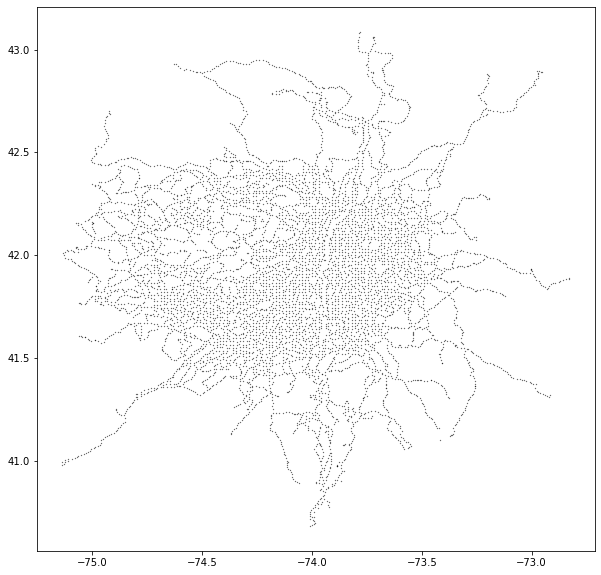

In [30]:
grid_pts = pd.read_feather(
    os.path.join(config.MODEL_PATH, 'grid_pts_67.feather'.format(pts_per_degree))
)
plt.figure(figsize=(10, 10))
plt.plot(grid_pts.lon, grid_pts.lat, 'k.', markersize=0.5)

In [27]:
pts_per_degree = 500

grid_pts, rtes_at_grid, gridpts_at_rte = (
    road_backbone.make_road_backbone(trips.index.tolist(), 
                                     pts_per_degree)
)

# And save
config.save_df(grid_pts, config.MODEL_PATH
               'grid_pts_{}.feather'.format(pts_per_degree))
config.save_df(rtes_at_grid, config.MODEL_PATH,
              'rtes_at_grid_{}.feather'.format(pts_per_degree))
config.save_df(gridpts_at_rte, config.MODEL_PATH, 
              'gridpts_at_rte_{}.feather'.format(pts_per_degree))

Looping through route IDs
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
Total unique grid points: 92349


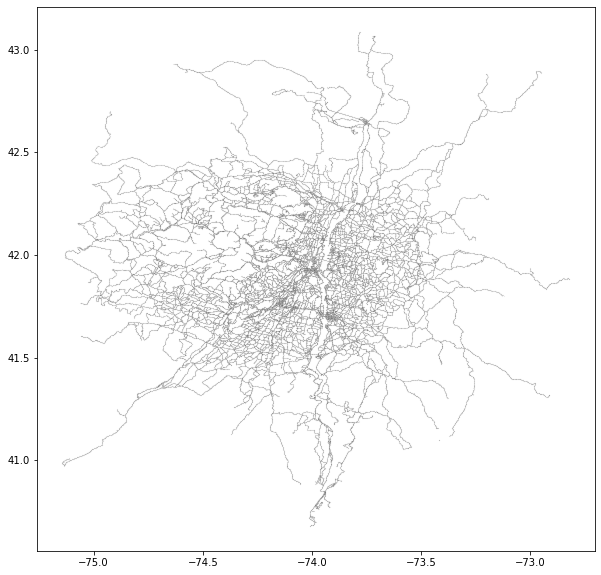

In [28]:
grid_pts = pd.read_feather(
    os.path.join(config.MODEL_PATH, 'grid_pts_500.feather'.format(pts_per_degree))
)
plt.figure(figsize=(10, 10))
plt.plot(grid_pts.lon, grid_pts.lat, 'k.', markersize=0.05)